# Data Modeling - Churn Prediction

## Vue d'ensemble du notebook

Ce notebook effectue l'entraînement et l'évaluation de trois modèles de classification supervisée pour prédire le churn des clients bancaires:

1. **Logistic Regression** - Un modèle linéaire simple et interprétable
2. **Random Forest** - Un ensemble d'arbres de décision robuste au surapprentissage
3. **XGBoost** - Un modèle de gradient boosting hautement performant

Chaque modèle est évalué à l'aide de métriques de classification standard (accuracy, precision, recall, F1-score, ROC-AUC) et de la validation croisée pour assurer la robustesse des résultats.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
import shape # for model interpretability
import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from ValidationCross import cross_val_results
import shap

## 1. Chargement et exploration des données

Nous chargeons les données prétraitées depuis le fichier CSV. Ces données ont déjà été nettoyées et préparées dans les étapes précédentes du pipeline.


In [ ]:
#load the preprocessed data
df = pd.read_csv("../data/preprocessed_data.csv") 
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Ratio_Balance_Age,Ratio_Salary_Age,Engagement_Score,Ratio_Products_Age,Relative_Salary,Ratio_CreditScore_Age,Zero_Balance_HasCrCard,Low_Balance_Active,Active_HasCrCard,Log_Salary
0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,...,2527.303265,2830.627551,4.0,0.040816,1.161679,13.938776,False,False,1.0,11.840081
1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,...,0.000000,4890.790667,4.0,0.066667,1.248591,20.266667,True,True,1.0,11.896313
2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,...,0.000000,2964.800000,3.0,0.031250,0.807356,16.843750,True,True,1.0,11.460311
3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,...,0.000000,4561.459744,2.0,0.051282,1.511382,13.589744,False,False,0.0,12.088965
4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,...,0.000000,2594.403111,4.0,0.044444,0.993504,13.622222,True,True,1.0,11.667783


In [4]:
# Define features and target variable
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [5]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Construction du préprocesseur

Nous créons un pipeline de prétraitement qui:
1. **Normalise** les variables numériques (StandardScaler)
2. **Encode** les variables catégoriques (OneHotEncoder)



In [6]:
# Identify numerical and categorical columns
num_var = X.select_dtypes(include=["float64", "int64"]).columns
cat_var = X.select_dtypes(include=["object","category"]).columns

In [7]:
# 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),           
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
    ]
)

##  Entraînement des modèles

Nous entraînons trois modèles de classification:

### Logistic Regression
- **Type**: Modèle linéaire
- **Avantages**: Simple, rapide, hautement interprétable
- **Paramètres clés**: 
  - `max_iter=1000` : nombre d'itérations
  - `class_weight='balanced'` : gère le déséquilibre des classes

### Random Forest
- **Type**: Ensemble d'arbres de décision
- **Avantages**: Robuste au surapprentissage, gère les non-linéarités
- **Paramètres clés**: 
  - `n_estimators=300` : nombre d'arbres
  - `max_depth=10` : profondeur maximale de chaque arbre
  - `class_weight='balanced'` : gère le déséquilibre

### XGBoost
- **Type**: Gradient Boosting
- **Avantages**: Très performant, gère bien les données complexes
- **Paramètres clés**: 
  - `n_estimators=300` : nombre de boosting rounds
  - `learning_rate=0.05` : vitesse d'apprentissage
  - `scale_pos_weight=3` : pénalité pour la classe minoritaire (churn)


=== Logistic Regression ===
Accuracy: 0.8116666666666666
Precision: 0.5174234424498416
Recall: 0.8193979933110368
F1-score: 0.6343042071197411
AUC: 0.8911971350518938

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      2402
           1       0.52      0.82      0.63       598

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.83      3000



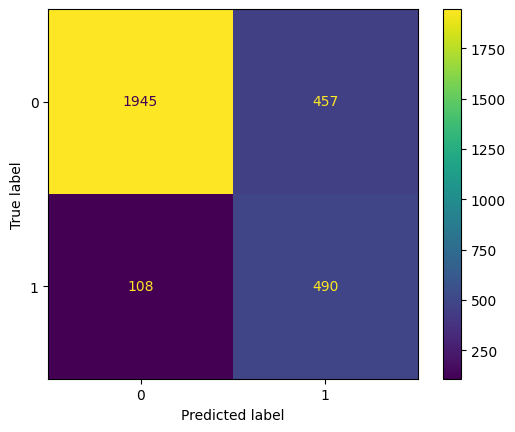


=== Random Forest ===
Accuracy: 0.8833333333333333
Precision: 0.6845238095238095
Recall: 0.7692307692307693
F1-score: 0.7244094488188977
AUC: 0.9297825947719155

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.68      0.77      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.84      0.83      3000
weighted avg       0.89      0.88      0.89      3000



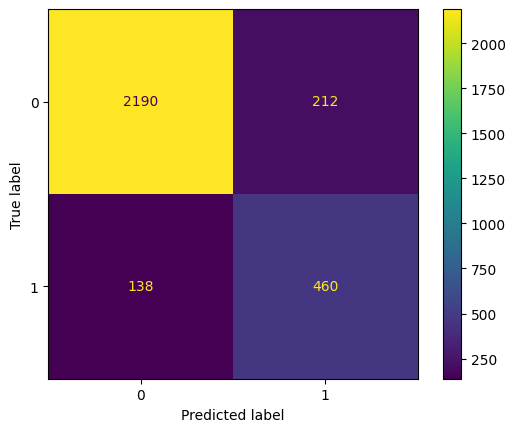

c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Accuracy: 0.882
Precision: 0.6728045325779037
Recall: 0.794314381270903
F1-score: 0.7285276073619632
AUC: 0.9313044592159823

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2402
           1       0.67      0.79      0.73       598

    accuracy                           0.88      3000
   macro avg       0.81      0.85      0.83      3000
weighted avg       0.89      0.88      0.89      3000



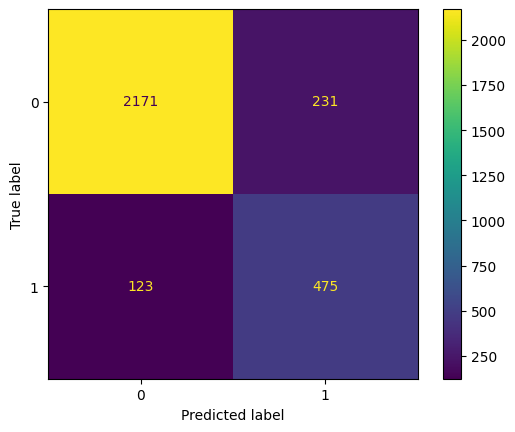

In [8]:
# ===========================
# Logistic Regression Model
# ===========================
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
evaluate_model(y_test, y_pred_lr, y_prob_lr)


# ===========================
# Random Forest Model
# ===========================
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
evaluate_model(y_test, y_pred_rf, y_prob_rf)


# ===========================
# XGBoost Model
# ===========================
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,  # gérer le déséquilibre
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False  # Important pour éviter les warnings
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

## Validation croisée

La validation croisée évalue la performance de chaque modèle de manière plus robuste en:
1. Divisant les données d'entraînement en plusieurs folds
2. Entraînant le modèle sur chaque combinaison de folds
3. Calculant la moyenne et l'écart-type des métriques

Cela permet de vérifier que le modèle généralise bien et ne souffre pas de surapprentissage ou sous-apprentissage.


In [10]:
# ===========================
# Validation croisée sur les modèles
# ===========================
print("=== Cross Validation: Logistic Regression ===")
cross_val_results(log_reg, X_train, y_train)

print("=== Cross Validation: Random Forest ===")
cross_val_results(rf, X_train, y_train)

print("=== Cross Validation: XGBoost ===")
cross_val_results(xgb, X_train, y_train)


=== Cross Validation: Logistic Regression ===
----- Cross Validation Scores -----
accuracy: 0.8129 ± 0.0089
precision: 0.5200 ± 0.0142
recall: 0.8052 ± 0.0131
f1: 0.6319 ± 0.0142
roc_auc: 0.8851 ± 0.0090


=== Cross Validation: Random Forest ===
----- Cross Validation Scores -----
accuracy: 0.8893 ± 0.0050
precision: 0.7020 ± 0.0124
recall: 0.7730 ± 0.0131
f1: 0.7358 ± 0.0118
roc_auc: 0.9318 ± 0.0056


=== Cross Validation: XGBoost ===
----- Cross Validation Scores -----
accuracy: 0.8858 ± 0.0030
precision: 0.6829 ± 0.0084
recall: 0.7972 ± 0.0075
f1: 0.7356 ± 0.0064
roc_auc: nan ± nan




## Importance des features - XGBoost

L'importance des features dans XGBoost mesure la contribution de chaque variable à la prédiction. Elle est calculée en fonction du nombre de fois qu'une feature est utilisée pour diviser les données dans les arbres et du gain qu'elle apporte.


In [ ]:
# Feature Importance  for XGBoost with xgb feature importance
xgb_model = xgb.named_steps['model']
importances = xgb_model.feature_importances_
feature_names = xgb.named_steps['preprocess'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance_df

,Feature,Importance
4,num__NumOfProducts,0.219753
12,num__Ratio_Products_Age,0.216664
1,num__Age,0.068051
6,num__IsActiveMember,0.062159
18,cat__Geography_Germany,0.058839
20,cat__Gender_Female,0.040244
11,num__Engagement_Score,0.039202
21,cat__Gender_Male,0.035542
3,num__Balance,0.025899
17,cat__Geography_France,0.024076


### Visualisation des features importantes

Ce graphique en barres représente l'importance de chaque feature, ordonnée par ordre décroissant. Plus la barre est longue, plus la feature est importante pour les prédictions du modèle.

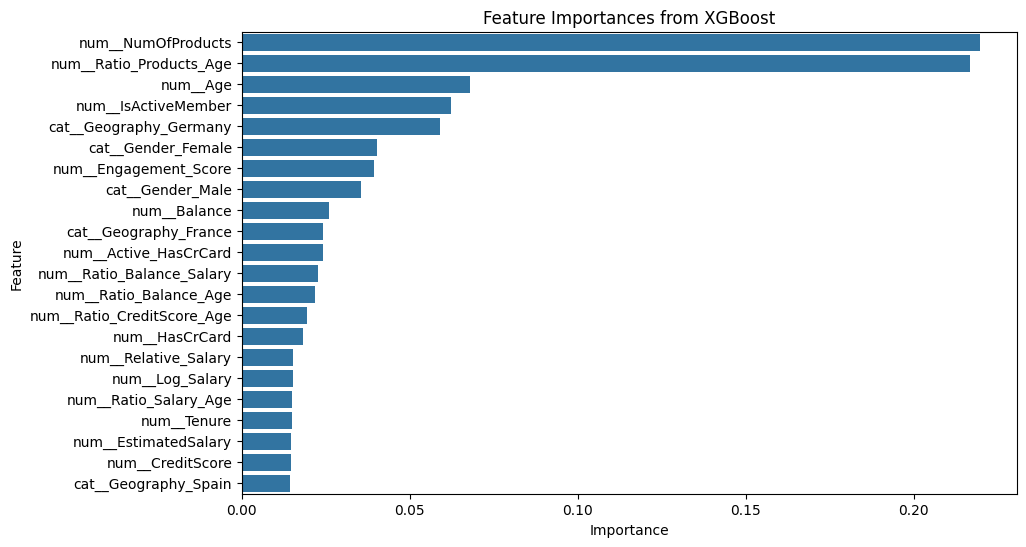

In [18]:
# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Analyse SHAP (SHapley Additive exPlanations)

SHAP est une méthode théorique du jeu qui explique les prédictions en attribuant à chaque feature une "valeur de contribution" pour chaque prédiction. 

**Avantages de SHAP**:
- Interprétabilité locale : comprendre pourquoi le modèle a fait une prédiction spécifique
- Interprétabilité globale : comprendre l'importance moyenne de chaque feature
- Fiable théoriquement : basé sur les valeurs de Shapley

In [11]:
# SHAP Feature Importance for XGBoost with Pipeline

# Extract the preprocessor and model from the pipeline
preprocessor_xgb = xgb.named_steps['preprocess']
xgb_model = xgb.named_steps['model']

# Preprocess the test data
X_test_preprocessed = preprocessor_xgb.transform(X_test)

# Create SHAP explainer with the raw XGBoost model (not the pipeline)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)


Nous récupérons les noms de features après le prétraitement pour les utiliser dans les visualisations SHAP.

In [12]:
# Get feature names after preprocessing
feature_names = (
    list(preprocessor_xgb.named_transformers_['num'].get_feature_names_out(num_var)) +
    list(preprocessor_xgb.named_transformers_['cat'].get_feature_names_out(cat_var))
)

print(f"Total features after preprocessing: {len(feature_names)}")

Total features after preprocessing: 22


### SHAP Summary Plot (Bee Swarm)

Ce graphique montre comment chaque feature affecte les prédictions du modèle:
- **Axe X**: Valeur SHAP (impact sur la sortie du modèle)
- **Couleur**: Valeur de la feature (rouge = valeurs élevées, bleu = valeurs basses)
- **Position Y**: Les features ordonnées par importance
- **Chaque point**: Représente une prédiction pour une instance de test

**Interprétation**: Si les points rouges sont généralement à droite, cela signifie que les valeurs élevées de cette feature augmentent la probabilité de churn.


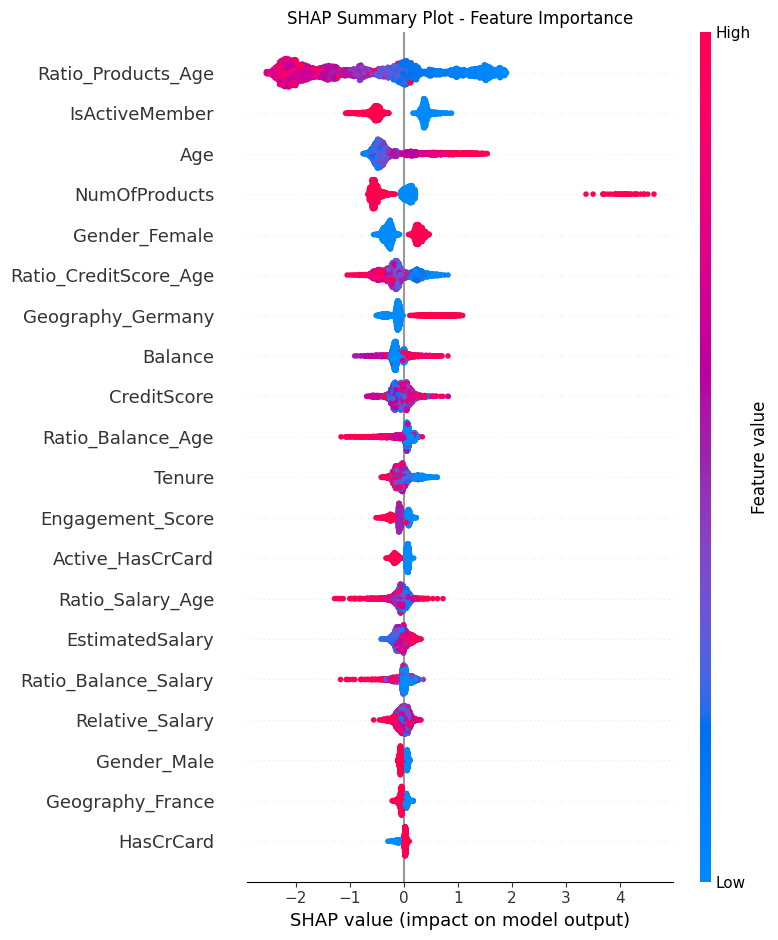

In [13]:
# SHAP summary plots
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Importance")
plt.tight_layout()
plt.show()


### SHAP Bar Plot (Importance)

Ce graphique montre l'importance moyenne de chaque feature en termes de valeur absolue SHAP:
- Les valeurs SHAP élevées (en valeur absolue) indiquent que la feature a un grand impact sur les prédictions
- C'est une vue d'ensemble de l'importance globale des features, indépendante de la direction de l'impact

C'est essentiellement la même information que le graphique d'importance XGBoost, mais calculée différemment et plus interprétable.

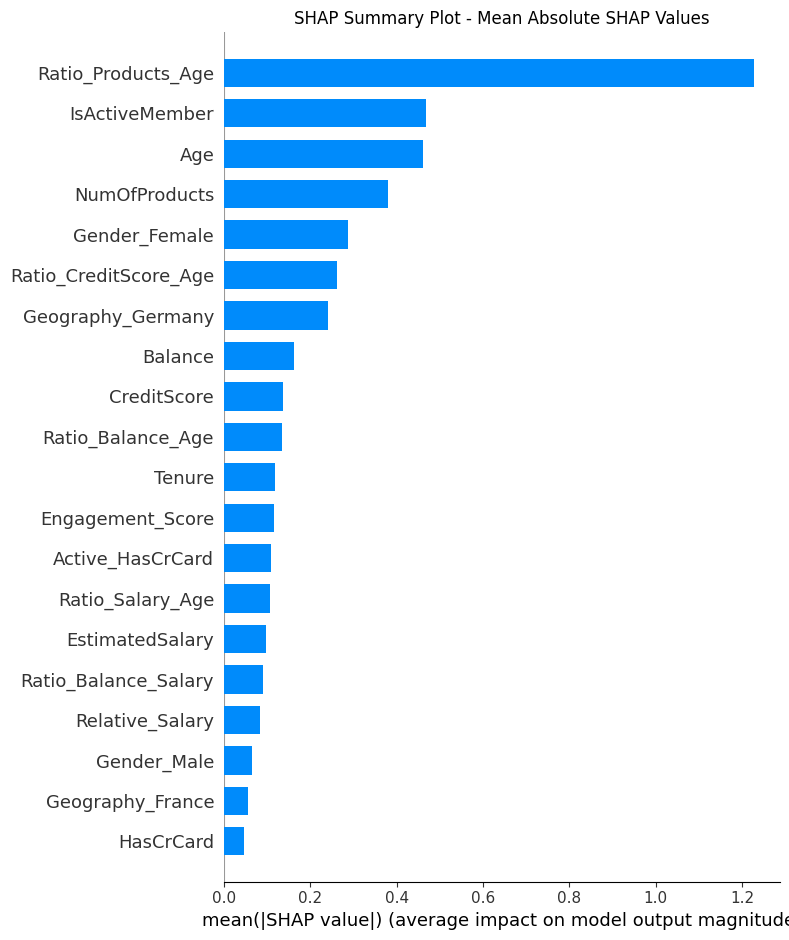

In [14]:
# Bar plot (mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Mean Absolute SHAP Values")
plt.tight_layout()
plt.show()


### Features les plus importantes

Ce résumé textuel affiche les features avec les plus hautes valeurs moyennes absolues SHAP. Ces features sont les plus influentes pour les prédictions du modèle XGBoost.

In [24]:
# Important features
features_idx = np.argsort(np.abs(shap_values).mean(axis=0))
print("\ Important features:")
for idx in reversed(features_idx):
    print(f"  {feature_names[idx]}: {np.abs(shap_values[:, idx]).mean():.4f}")

\ Important features:
  Ratio_Products_Age: 1.2264
  IsActiveMember: 0.4679
  Age: 0.4618
  NumOfProducts: 0.3798
  Gender_Female: 0.2871
  Ratio_CreditScore_Age: 0.2613
  Geography_Germany: 0.2410
  Balance: 0.1625
  CreditScore: 0.1358
  Ratio_Balance_Age: 0.1350
  Tenure: 0.1170
  Engagement_Score: 0.1166
  Active_HasCrCard: 0.1083
  Ratio_Salary_Age: 0.1073
  EstimatedSalary: 0.0966
  Ratio_Balance_Salary: 0.0893
  Relative_Salary: 0.0840
  Gender_Male: 0.0651
  Geography_France: 0.0560
  HasCrCard: 0.0455
  Log_Salary: 0.0307
  Geography_Spain: 0.0146
